# Inflow-Mean Sounding Code for WoFS

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Allows interrogation of sensitivity fields to then produce spatially-averaged ensemble mean vertical profiles within the specified inflow bounds.
### Reproduces Figs. 9, 13c, and S5a

In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT

import wofs_cbook_mod_part2 as wcalc
import centered_response as cr
from wofunits import wofunits
from wofs_colortables import cb_colors

import warnings
warnings.filterwarnings("ignore")

## Manually set case, time, inflow domain specs, etc. for the desired plotting

In [2]:
################################ Set case/plotting specs  #######################################

    # save scatter plots?
save = False

    # select case
#case = '201905172100'
#case = '201905172200'
case = '201905202030'
#case = '201905262000'
#case = '201905282230'

    # select time and variables
lead_time = 30 # lead time in minutes
statevar, respvar = 'MLCAPE','UH25-30MIN'

    # domain thresholding specs
inflow_region = 'nf'
pthres = 0.05
pstat_sign = 'all'
ang_thres = 360
nf_dist = 40 # distance bound of near-inflow domain
ff_dist = 120 # distance bound of far-inflow domain
ang_bound1, ang_bound2 = 40, 230 # angular domain bounds relative to the storm motion
domain_lag = 0 # distance lag of domain origin to storm center in km

    # define common directories for file paths
sensdir = wofunits.paths['sens_path'] # sensitivity file path
respdir_sr = wofunits.paths['resp_path'] # response function file path
wofsdir = wofunits.paths['wofs_path'] # WoFS data path
wofsdir_3d = wofunits.paths['wofs_path_3d'] # 3D WoFS data path
sm_path = wofunits.paths['sm_path'] # storm motion data path
outplot_path = wofunits.paths['outplot_path'] # plot output path

## Process selected case/plotting specs

In [3]:
################################ Process case/plotting specs  #######################################
    
    # pull case specs
wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)

respvar_filestr = respvar.replace('-','_')

    # define state and response time as datetime objects
resp_time = datetime.datetime.strptime(resptime, '%Y-%m-%d_%H_%M_%S')
state_time = resp_time - datetime.timedelta(minutes=lead_time)

    # define file strings for given variables and time
file_sens = f'{sensdir}/sens_center_{case}/stats_{respvar}_max_{str(resp_time.hour).zfill(2)}_{str(resp_time.minute).zfill(2)}_00_{statevar}_{str(state_time.hour).zfill(2)}_{str(state_time.minute).zfill(2)}_00.nc'
file_resp_sr = f'{respdir_sr}/resp_{respvar_filestr}_max_{resptime}.nc'
file_ref = f'{wofsdir}/wofs_{case[:8]}_{case[8:]}/wofs_center_i{case}_v{state_time.year}{str(state_time.month).zfill(2)}{str(state_time.day).zfill(2)}{str(state_time.hour).zfill(2)}{str(state_time.minute).zfill(2)}.nc'
file_3d = f'{wofsdir_3d}/wofs_{case[:8]}_{case[8:]}/wofs_3dcenter_i{case}_v{state_time.year}{str(state_time.month).zfill(2)}{str(state_time.day).zfill(2)}{str(state_time.hour).zfill(2)}{str(state_time.minute).zfill(2)}.nc'

    # open netCDF files
ds_sens = xr.open_dataset(file_sens)
ds_ref = xr.open_dataset(file_ref)
ds_3d = xr.open_dataset(file_3d)
ds_resp_sr = xr.open_dataset(file_resp_sr)

    # define variables for overview plots
sens = ds_sens.stdsens
cref = np.where(np.nanmean(ds_ref.REFD_MAX, axis=0) < 10, np.nan, np.nanmean(ds_ref.REFD_MAX, axis=0))[0]
pstat = ds_sens.pstat.values

    # define response variables
uhresp_sr = ds_resp_sr[respvar_filestr]

    # define tercile indices
upp_terc = wofunits.rankidx[case][respvar][:12]
low_terc = wofunits.rankidx[case][respvar][24:]

    # define PBL scheme indices
ysu_idx = wofunits.schemeidx['ysu']
myj_idx = wofunits.schemeidx['myj']
mynn_idx = wofunits.schemeidx['mynn']

################################ Define storm-relative aspects  #######################################

    # define observed MRMS storm centers to center storm on plot
df_center = cr.create_mrmscenter_df(file_coords, file_mrms_maxima)

    # string to 
pdstr = f'{state_time.year}-{str(state_time.month).zfill(2)}-{str(state_time.day).zfill(2)} {str(state_time.hour).zfill(2)}:{str(state_time.minute).zfill(2)}:00'

    # open storm motion csv files
sm_x = pd.read_csv(f'{sm_path}/{case}_motions_nx.csv', index_col='Member')
sm_y = pd.read_csv(f'{sm_path}/{case}_motions_ny.csv', index_col='Member')

    # average storm motion components at chosen time
sm_mean_x = np.nanmean(sm_x[:-1][pdstr].values)
sm_mean_y = np.nanmean(sm_y[:-1][pdstr].values)

    # calculate angle of storm motion relative to positive x-axis
storm_ang = cr.calc_storm_ang(sm_mean_x, sm_mean_y)

    # create 2D x and y storm-relative grids
xmesh,ymesh = cr.xy_mesh(case, state_time)
dist = (xmesh**2 + ymesh**2)**0.5 # convert to 2D meshgrid

    # calculate storm-relative angle of each gridpoint 
ang_tot = cr.calc_ang_tot(xmesh,ymesh,storm_ang=storm_ang)

    # calculate angle difference between SR gridpoint position and SR 
ang_diff = cr.srw_ang_diff(case, state_time)

## Plot sensitivity for interrogation

Text(0.5, 1.0, 'MLCAPE Sensitivity at 30-min lead time')

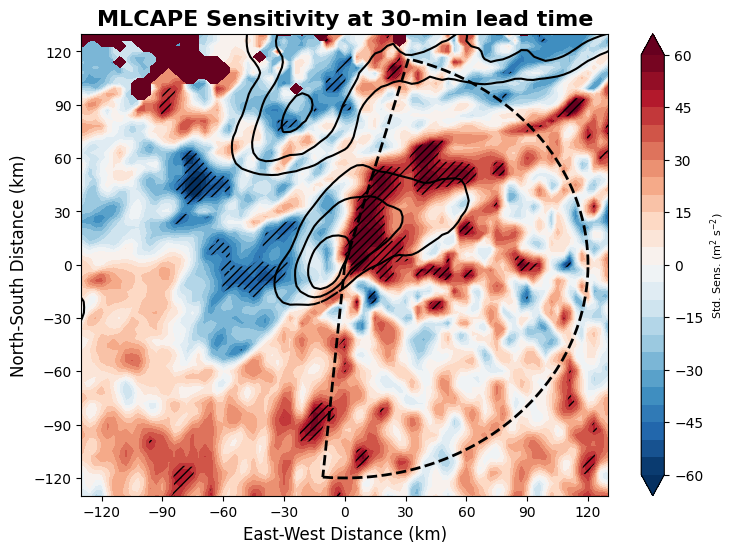

In [4]:
################# Plot sensitivity ######################

fig = plt.figure(figsize=(8.5,6))

cb = plt.contourf(xmesh, ymesh, sens, cmap='RdBu_r', levels=np.arange(-60,61,5), extend='both')

plt.contour(xmesh, ymesh, cref, levels=[20,35,50], colors='k')

plt.contourf(xmesh, ymesh, abs(pstat), [0, 0.1], colors='none', hatches=['////'], extend='lower')

cr.plot_domain(storm_ang = storm_ang, 
            ang_bounds = (ang_bound1, ang_bound2))

plt.xticks(np.arange(-120,121,30))
plt.yticks(np.arange(-120,121,30))

cbar = plt.colorbar(cb, label=wofunits.labels['UH-30SWT25'])
cbar.set_label(label=f'Std. Sens. ({wofunits.labels[respvar]})', size=8)

plt.xlim(-130,130)
plt.ylim(-130,130)

plt.xlabel('East-West Distance (km)', size=12)
plt.ylabel('North-South Distance (km)', size=12)

plt.title(f'{statevar} Sensitivity at {int((resp_time - state_time).seconds/60)}-min lead time', weight='bold', size=16)

## Pull 3D profiles and threshold based on spec settings

In [5]:

# define 3D state variables
u = ds_3d.U[:,0].values
v = ds_3d.V[:,0].values
z = ds_3d.Z_AGL[:,0].values
p = ds_3d.P[:,0].values/100
t = ds_3d.T[:,0].values - 273.15
td = ds_3d.TD[:,0].values
dz = ds_3d.DZ[:,0].values

    # define 3D thresholding variables 
dist_3d = np.stack([np.stack([dist]*50)]*36)
ang_tot_3d = np.stack([np.stack([ang_tot]*50)]*36)
ang_diff_3d = np.stack([np.stack([ang_diff]*50)]*36)
pstat_3d_ = np.stack([np.stack([pstat]*50)]*36)

    # handle pstat_sign spec setting
if pstat_sign == '+':
    pstat_3d = abs(np.where(pstat_3d_ <= 0, np.nan, pstat_3d_))
    #pstat_3d = np.where(pstat_3d > pthres, np.nan, pstat_3d)
elif pstat_sign == '-':
    pstat_3d = abs(np.where(pstat_3d_ > 0, np.nan, pstat_3d_))
elif pstat_sign == 'all':
    pstat_3d = abs(pstat_3d_)

    # threshold 3D profiles by inflow domain and sensitivity sign
if inflow_region == 'ff':
    u_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, u), axis=(2,3))
    v_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, v), axis=(2,3))
    z_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, z), axis=(2,3))
    p_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, p), axis=(2,3))
    t_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, t), axis=(2,3))
    td_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, td), axis=(2,3))
    dz_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, dz), axis=(2,3))
elif inflow_region == 'nf':
    u_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, u), axis=(2,3))
    v_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, v), axis=(2,3))
    z_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, z), axis=(2,3))
    p_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, p), axis=(2,3))
    t_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, t), axis=(2,3))
    td_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, td), axis=(2,3))
    dz_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, dz), axis=(2,3))
elif inflow_region == 'if':
    u_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, u), axis=(2,3))
    v_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, v), axis=(2,3))
    z_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, z), axis=(2,3))
    p_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, p), axis=(2,3))
    t_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, t), axis=(2,3))
    td_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, td), axis=(2,3))
    dz_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, dz), axis=(2,3))   

## Sort and average 3D data by tercile, PBL scheme

In [6]:

    # pull variables by UH tercile
u_upp = u_thres[upp_terc,:]
v_upp = v_thres[upp_terc,:]
z_upp = z_thres[upp_terc,:]
p_upp = p_thres[upp_terc,:]
t_upp = t_thres[upp_terc,:]
td_upp = td_thres[upp_terc,:]
dz_upp = dz_thres[upp_terc,:]
          
u_low = u_thres[low_terc,:]
v_low = v_thres[low_terc,:]
z_low = z_thres[low_terc,:]
p_low = p_thres[low_terc,:]
t_low = t_thres[low_terc,:]
td_low = td_thres[low_terc,:]
dz_low = dz_thres[low_terc,:]

    # pull variables by PBL scheme
z_ysu = z_thres[ysu_idx,:]
z_myj = z_thres[myj_idx,:]
z_mynn = z_thres[mynn_idx,:]

p_ysu = p_thres[ysu_idx,:]
p_myj = p_thres[myj_idx,:]
p_mynn = p_thres[mynn_idx,:]

u_ysu = u_thres[ysu_idx,:]
u_myj = u_thres[myj_idx,:]
u_mynn = u_thres[mynn_idx,:]

v_ysu = v_thres[ysu_idx,:]
v_myj = v_thres[myj_idx,:]
v_mynn = v_thres[mynn_idx,:]

    # take means of tercile thresholded variables
u_upp_mean = np.nanmean(u_upp, axis=0)
v_upp_mean = np.nanmean(v_upp, axis=0)
z_upp_mean = np.nanmean(z_upp, axis=0)
t_upp_mean = np.nanmean(t_upp, axis=0)
td_upp_mean = np.nanmean(td_upp, axis=0)
p_upp_mean = np.nanmean(p_upp, axis=0)

u_low_mean = np.nanmean(u_low, axis=0)
v_low_mean = np.nanmean(v_low, axis=0)
z_low_mean = np.nanmean(z_low, axis=0)
t_low_mean = np.nanmean(t_low, axis=0)
td_low_mean = np.nanmean(td_low, axis=0)
p_low_mean = np.nanmean(p_low, axis=0)

    # take means of PBL sorted variables
z_ysu_mean = np.nanmean(z_ysu, axis=0)
z_myj_mean = np.nanmean(z_myj,axis=0)
z_mynn_mean = np.nanmean(z_mynn,axis=0)

p_ysu_mean = np.nanmean(p_ysu,axis=0)
p_myj_mean = np.nanmean(p_myj,axis=0)
p_mynn_mean = np.nanmean(p_mynn,axis=0)

u_ysu_mean = np.nanmean(u_ysu, axis=0)
u_myj_mean = np.nanmean(u_myj,axis=0)
u_mynn_mean = np.nanmean(u_mynn,axis=0)

v_ysu_mean = np.nanmean(v_ysu,axis=0)
v_myj_mean = np.nanmean(v_myj,axis=0)
v_mynn_mean = np.nanmean(v_mynn,axis=0)

## Process mean profiles for plotting

In [7]:

# pull elevation labeling points from mean profiles
ulowpt_1km = np.interp(1000, z_low_mean, u_low_mean)
ulowpt_3km = np.interp(3000, z_low_mean, u_low_mean)
ulowpt_6km = np.interp(6000, z_low_mean, u_low_mean)
ulowpt_12km = np.interp(12000, z_low_mean, u_low_mean)
vlowpt_1km = np.interp(1000, z_low_mean, v_low_mean)
vlowpt_3km = np.interp(3000, z_low_mean, v_low_mean)
vlowpt_6km = np.interp(6000, z_low_mean, v_low_mean)
vlowpt_12km = np.interp(12000, z_low_mean, v_low_mean)

uupppt_1km = np.interp(1000, z_upp_mean, u_upp_mean)
uupppt_3km = np.interp(3000, z_upp_mean, u_upp_mean)
uupppt_6km = np.interp(6000, z_upp_mean, u_upp_mean)
uupppt_12km = np.interp(12000, z_upp_mean, u_upp_mean)
vupppt_1km = np.interp(1000, z_upp_mean, v_upp_mean)
vupppt_3km = np.interp(3000, z_upp_mean, v_upp_mean)
vupppt_6km = np.interp(6000, z_upp_mean, v_upp_mean)
vupppt_12km = np.interp(12000, z_upp_mean, v_upp_mean)

    # pull elevation labeling points from PBL scheme profiles
uysupt_1km = np.interp(1000, z_ysu_mean, u_ysu_mean)
uysupt_3km = np.interp(3000, z_ysu_mean, u_ysu_mean)
uysupt_6km = np.interp(6000, z_ysu_mean, u_ysu_mean)
uysupt_12km = np.interp(12000, z_ysu_mean, u_ysu_mean)
vysupt_1km = np.interp(1000, z_ysu_mean, v_ysu_mean)
vysupt_3km = np.interp(3000, z_ysu_mean, v_ysu_mean)
vysupt_6km = np.interp(6000, z_ysu_mean, v_ysu_mean)
vysupt_12km = np.interp(12000, z_ysu_mean, v_ysu_mean)

umyjpt_1km = np.interp(1000, z_myj_mean, u_myj_mean)
umyjpt_3km = np.interp(3000, z_myj_mean, u_myj_mean)
umyjpt_6km = np.interp(6000, z_myj_mean, u_myj_mean)
umyjpt_12km = np.interp(12000, z_myj_mean, u_myj_mean)
vmyjpt_1km = np.interp(1000, z_myj_mean, v_myj_mean)
vmyjpt_3km = np.interp(3000, z_myj_mean, v_myj_mean)
vmyjpt_6km = np.interp(6000, z_myj_mean, v_myj_mean)
vmyjpt_12km = np.interp(12000, z_myj_mean, v_myj_mean)

umynnpt_1km = np.interp(1000, z_mynn_mean, u_mynn_mean)
umynnpt_3km = np.interp(3000, z_mynn_mean, u_mynn_mean)
umynnpt_6km = np.interp(6000, z_mynn_mean, u_mynn_mean)
umynnpt_12km = np.interp(12000, z_mynn_mean, u_mynn_mean)
vmynnpt_1km = np.interp(1000, z_mynn_mean, v_mynn_mean)
vmynnpt_3km = np.interp(3000, z_mynn_mean, v_mynn_mean)
vmynnpt_6km = np.interp(6000, z_mynn_mean, v_mynn_mean)
vmynnpt_12km = np.interp(12000, z_mynn_mean, v_mynn_mean)

    # list altitude points for terciles
upppts = [u_upp_mean[0], v_upp_mean[0], uupppt_1km, vupppt_1km, uupppt_3km, vupppt_3km, uupppt_6km, vupppt_6km, uupppt_12km, vupppt_12km]
lowpts = [u_low_mean[0], v_low_mean[0], ulowpt_1km, vlowpt_1km, ulowpt_3km, vlowpt_3km, ulowpt_6km, vlowpt_6km, ulowpt_12km, vlowpt_12km]

    # list altitude points for PBL schemes
ysupts = [u_ysu_mean[0], v_ysu_mean[0], uysupt_1km, vysupt_1km, uysupt_3km, vysupt_3km, uysupt_6km, vysupt_6km, uysupt_12km, vysupt_12km]
myjpts = [u_myj_mean[0], v_myj_mean[0], umyjpt_1km, vmyjpt_1km, umyjpt_3km, vmyjpt_3km, umyjpt_6km, vmyjpt_6km, umyjpt_12km, vmyjpt_12km]
mynnpts = [u_mynn_mean[0], v_mynn_mean[0], umynnpt_1km, vmynnpt_1km, umynnpt_3km, vmynnpt_3km, umynnpt_6km, vmynnpt_6km, umynnpt_12km, vmynnpt_12km]


    # threshold mean tercile profiles to 12 km
z_, u_upp_12km, v_upp_12km = mpcalc.get_layer_heights(z_upp_mean*units.meter,
                                         12000*units.meter,
                                         u_upp_mean*units.meter_per_second,
                                         v_upp_mean*units.meter_per_second)

z_, u_low_12km, v_low_12km = mpcalc.get_layer_heights(z_low_mean*units.meter,
                                         12000*units.meter,
                                         u_low_mean*units.meter_per_second,
                                         v_low_mean*units.meter_per_second)

    # threshold mean PBL sorted profiles to 12 km
z_, u_ysu_12km, v_ysu_12km = mpcalc.get_layer_heights(z_ysu_mean*units.meter,
                                         12000*units.meter,
                                         u_ysu_mean*units.meter_per_second,
                                         v_ysu_mean*units.meter_per_second)

z_, u_myj_12km, v_myj_12km = mpcalc.get_layer_heights(z_myj_mean*units.meter,
                                         12000*units.meter,
                                         u_myj_mean*units.meter_per_second,
                                         v_myj_mean*units.meter_per_second)

z_, u_mynn_12km, v_mynn_12km = mpcalc.get_layer_heights(z_mynn_mean*units.meter,
                                         12000*units.meter,
                                         u_mynn_mean*units.meter_per_second,
                                         v_mynn_mean*units.meter_per_second)

    # threshold member tercile profiles to 12 km
u_upps_12km = []
v_upps_12km = []
for i in range(len(p_upp)):
    z_, uvar, vvar = mpcalc.get_layer_heights(z_upp[i]*units.meter,
                                         12000*units.meter,
                                         u_upp[i]*units.meter_per_second,
                                         v_upp[i]*units.meter_per_second)
    u_upps_12km.append(uvar)
    v_upps_12km.append(vvar)
    
u_lows_12km = []
v_lows_12km = []
for i in range(len(p_low)):
    z_, uvar, vvar = mpcalc.get_layer_heights(z_low[i]*units.meter,
                                         12000*units.meter,
                                         u_low[i]*units.meter_per_second,
                                         v_low[i]*units.meter_per_second)
    u_lows_12km.append(uvar)
    v_lows_12km.append(vvar)


    # threshold member PBL sorted profiles to 12 km
u_ysus_12km = []
v_ysus_12km = []
for i in range(len(p_myj)):
    z_, uvar, vvar = mpcalc.get_layer_heights(z_ysu[i]*units.meter,
                                         12000*units.meter,
                                         u_ysu[i]*units.meter_per_second,
                                         v_ysu[i]*units.meter_per_second)
    u_ysus_12km.append(uvar)
    v_ysus_12km.append(vvar)
    
u_myjs_12km = []
v_myjs_12km = []
for i in range(len(p_myj)):
    z_, uvar, vvar = mpcalc.get_layer_heights(z_myj[i]*units.meter,
                                         12000*units.meter,
                                         u_myj[i]*units.meter_per_second,
                                         v_myj[i]*units.meter_per_second)
    u_myjs_12km.append(uvar)
    v_myjs_12km.append(vvar)

u_mynns_12km = []
v_mynns_12km = []
for i in range(len(p_mynn)):
    z_, uvar, vvar = mpcalc.get_layer_heights(z_mynn[i]*units.meter,
                                         12000*units.meter,
                                         u_mynn[i]*units.meter_per_second,
                                         v_mynn[i]*units.meter_per_second)
    u_mynns_12km.append(uvar)
    v_mynns_12km.append(vvar)

    
    # pull and average variables by PBL scheme
p_ysu = np.nanmean(p_thres[ysu_idx,:],axis=0)
p_myj = np.nanmean(p_thres[myj_idx,:],axis=0)
p_mynn = np.nanmean(p_thres[mynn_idx,:],axis=0)

t_ysu = np.nanmean(t_thres[ysu_idx,:],axis=0)
t_myj = np.nanmean(t_thres[myj_idx,:],axis=0)
t_mynn = np.nanmean(t_thres[mynn_idx,:],axis=0)

td_ysu = np.nanmean(td_thres[ysu_idx,:],axis=0)
td_myj = np.nanmean(td_thres[myj_idx,:],axis=0)
td_mynn = np.nanmean(td_thres[mynn_idx,:],axis=0)

## Pull and process storm motion specs for plotting

In [8]:
# Open and process observed storm motions

sm_x = pd.read_csv(f'{sm_path}/{case}_motions_nx.csv', index_col='Member')
sm_y = pd.read_csv(f'{sm_path}/{case}_motions_ny.csv', index_col='Member')

    # intensity terciles
sm_x_upp = sm_x[:-1][pdstr][upp_terc].values
sm_y_upp = sm_y[:-1][pdstr][upp_terc].values
sm_x_low = sm_x[:-1][pdstr][low_terc].values
sm_y_low = sm_y[:-1][pdstr][low_terc].values

sm_x_upp_mean = np.nanmean(sm_x_upp)
sm_y_upp_mean = np.nanmean(sm_y_upp)
sm_x_low_mean = np.nanmean(sm_x_low)
sm_y_low_mean = np.nanmean(sm_y_low)


    # PBL scheme
sm_x_ysu = sm_x[:-1][pdstr][ysu_idx].values
sm_y_ysu = sm_y[:-1][pdstr][ysu_idx].values
sm_x_myj = sm_x[:-1][pdstr][myj_idx].values
sm_y_myj = sm_y[:-1][pdstr][myj_idx].values
sm_x_mynn = sm_x[:-1][pdstr][mynn_idx].values
sm_y_mynn = sm_y[:-1][pdstr][mynn_idx].values

sm_x_ysu_mean = np.nanmean(sm_x_ysu)
sm_y_ysu_mean = np.nanmean(sm_y_ysu)
sm_x_myj_mean = np.nanmean(sm_x_myj)
sm_y_myj_mean = np.nanmean(sm_y_myj)
sm_x_mynn_mean = np.nanmean(sm_x_mynn)
sm_y_mynn_mean = np.nanmean(sm_y_mynn)

## Plot upper- vs. lower-tercile hodographs for interrogation

Text(0.5, 1.0, 'Sensitive NF Gridpoints | Valid 2019-05-20 2200 UTC')

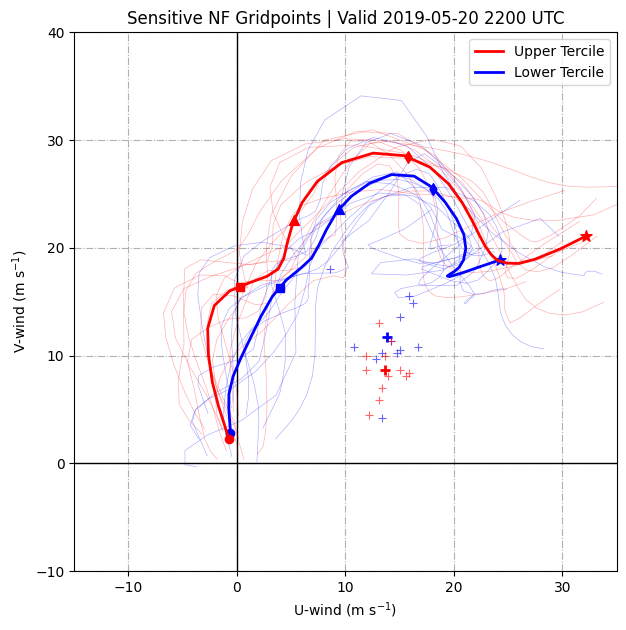

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

for u_, v_ in zip(u_upps_12km, v_upps_12km):
    ax.plot(u_,v_, lw=0.5, alpha=0.3, c='r', zorder=94, label='_nolegend_')
for u_, v_ in zip(u_lows_12km, v_lows_12km):
    ax.plot(u_,v_, lw=0.5, alpha=0.3, c='b', zorder=95, label='_nolegend_')
    
ax.plot(u_upp_12km, v_upp_12km, lw=2, c='r', zorder=98, label='Upper Tercile')
ax.plot(u_low_12km, v_low_12km, lw=2, c='b', zorder=96, label='Lower Tercile')

markers = ['o', 's', '^', 'd', '*'] #['o']*5 #['o', 's', '^', 'd', '*']
sizes = [35,35,50,35,70] #[130]*5
#z_kms = [0,1,3,6,12]

for i in range(int(len(upppts)/2)):
    ax.scatter(upppts[2*i], upppts[2*i+1], color='r', marker=markers[i], s=sizes[i], zorder=99) #facecolor='w'
    ax.scatter(lowpts[2*i], lowpts[2*i+1], color='b', marker=markers[i], s=sizes[i], zorder=97) #facecolor='w',
    #ax.text(upppts[2*i], upppts[2*i+1], z_kms[i], color='r', 
   #         horizontalalignment='center', verticalalignment='center', size=7, weight='bold', zorder=100)
   # ax.text(lowpts[2*i], lowpts[2*i+1], z_kms[i], color='b', 
   #         horizontalalignment='center', verticalalignment='center', size=7, weight='bold', zorder=98)
    
ax.scatter(sm_x_upp, sm_y_upp, s=30, marker='+', c='r', lw=0.8, alpha=0.6, zorder=112)
ax.scatter(sm_x_upp_mean, sm_y_upp_mean, s=60, marker='+', c='r', lw=2, zorder=113)

ax.scatter(sm_x_low, sm_y_low, s=30, marker='+', c='b', lw=0.8, alpha=0.6, zorder=110)
ax.scatter(sm_x_low_mean, sm_y_low_mean, s=60, marker='+', c='b', lw=2, zorder=111)

ax.set_xlabel('U-wind (m s$^{-1}$)')
ax.set_ylabel('V-wind (m s$^{-1}$)')

ax.grid(ls='-.', zorder=0)
ax.axhline(y=0, c='k', lw=1, zorder=2)
ax.axvline(x=0, c='k', lw=1, zorder=3)

ax.set_xlim(-15,35)
ax.set_ylim(-10,40)

ax.legend()

#sizes=np.arange(10,61,10)
#for i in sizes:
#    # plot circles corresponding to magnitudes
#    circle = plt.Circle((0,0), i, fill=False, color = 'gray', ls = '--', alpha=0.6)
#    ax.add_patch(circle)

#ax.scatter(ds_3d.U10[upp_terc,0,ny_sr,nx_sr], ds_3d.V10[upp_terc,0,ny_sr,nx_sr], s=20, c='r')
#ax.scatter(ds_3d.U10[low_terc,0,ny_sr,nx_sr], ds_3d.V10[low_terc,0,ny_sr,nx_sr], s=20, c='b')

validtime = pdstr[:16].replace(':','')
ax.set_title(f'Sensitive {inflow_region.upper()} Gridpoints | Valid {validtime} UTC',
                size=12)

## Calculate and print SRH stats by tercile

In [10]:
srh3_upp=[]
for i in range(len(upp_terc)):
    srh3_upp.append(wcalc.calc_srh_2d(z_agl=z_upp[i],
                   u=u_upp[i],
                   v=v_upp[i],
                   dz=dz_upp[i],
                   lower=0, upper=3000, sm_u=sm_x_upp[i], sm_v=sm_y_upp[i]))

srh3_low=[]
for i in range(len(low_terc)):
    srh3_low.append(wcalc.calc_srh_2d(z_agl=z_low[i],
                   u=u_low[i],
                   v=v_low[i],
                   dz=dz_low[i],
                   lower=0, upper=3000, sm_u=sm_x_low[i], sm_v=sm_y_low[i]))

print('Upper tercile:', np.nanmean(srh3_upp), wofunits.labels['SRH3'])
print('Lower tercile:', np.nanmean(srh3_low), wofunits.labels['SRH3'])

Upper tercile: 382.8635 m$^2$ s$^{-2}$
Lower tercile: 282.5637 m$^2$ s$^{-2}$


## Plot Fig. 9c,d: Hodographs by Tercile & PBL Scheme 

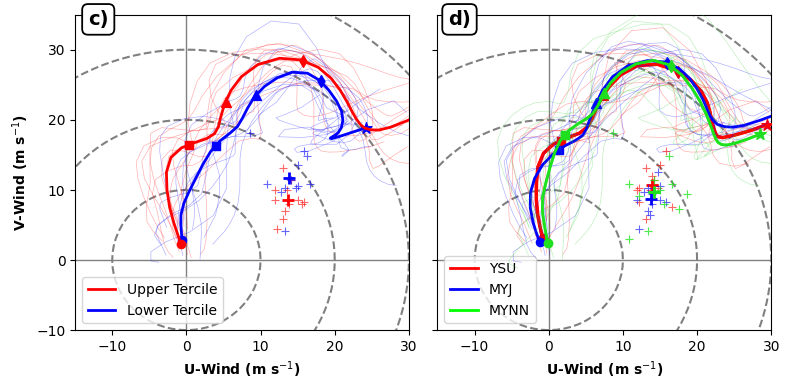

In [11]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs = axs.flatten()

x,y=np.meshgrid(np.arange(-100,101,1), np.arange(-100,101,1))


###################### Panel C ####################################################################

axs[0].contour(x,y, (x**2+y**2)**0.5, levels=np.arange(10,101,10), lw=2, linestyles='--', colors='gray')

for u_, v_ in zip(u_upps_12km, v_upps_12km):
    axs[0].plot(u_,v_, lw=0.5, alpha=0.3, c='r', zorder=94, label='_nolegend_')
for u_, v_ in zip(u_lows_12km, v_lows_12km):
    axs[0].plot(u_,v_, lw=0.5, alpha=0.3, c='b', zorder=95, label='_nolegend_')

axs[0].plot(u_upp_12km, v_upp_12km, lw=2, c='r', zorder=98, label='Upper Tercile')
axs[0].plot(u_low_12km, v_low_12km, lw=2, c='b', zorder=96, label='Lower Tercile')

for i in range(int(len(upppts)/2)):
    axs[0].scatter(upppts[2*i], upppts[2*i+1], color='r', marker=markers[i], s=sizes[i], zorder=99) #facecolor='w'
    axs[0].scatter(lowpts[2*i], lowpts[2*i+1], color='b', marker=markers[i], s=sizes[i], zorder=97) 

axs[0].scatter(sm_x_upp, sm_y_upp, s=30, marker='+', c='r', lw=0.8, alpha=0.6, zorder=110)
axs[0].scatter(sm_x_upp_mean, sm_y_upp_mean, s=80, marker='+', c='r', lw=2, zorder=113)

axs[0].scatter(sm_x_low, sm_y_low, s=30, marker='+', c='b', lw=0.8, alpha=0.6, zorder=110)
axs[0].scatter(sm_x_low_mean, sm_y_low_mean, s=80, marker='+', c='b', lw=2, zorder=111)

#axs.text(0.08, 0.98, labels[i], size=16, ha='center', va='center', weight='bold',
#            transform=axs.transAxes, bbox=dict(facecolor='w', edgecolor='k', boxstyle='round' ))

axs[0].legend(['Upper Tercile', 'Lower Tercile'], loc='lower left')
axs[0].set_xlabel('U-Wind (m s$^{-1}$)', size=10, weight='bold')
axs[0].set_ylabel('V-Wind (m s$^{-1}$)', size=10, weight='bold')

#axs.set_title(f'$\\alpha$ = {alphas[i]}°', size=16, weight='bold')
axs[0].set_xticks(np.arange(-10,31,10))
axs[0].set_yticks(np.arange(-10,31,10))

axs[0].axvline(x=0, lw=1, color='gray')
axs[0].axhline(y=0, lw=1, color='gray')

axs[0].set_xlim(-15,30)
axs[0].set_ylim(-10,35)

axs[0].text(0.10, 1.015, 'c)', transform=axs[0].transAxes, weight='bold',
              verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='w', edgecolor='k', pad=0.3, lw=1.3, boxstyle='round'), size=14)


###################### Panel D ####################################################################

axs[1].contour(x,y, (x**2+y**2)**0.5, levels=np.arange(10,101,10), lw=2, linestyles='--', colors='gray')

#axs.text(0.08, 0.98, labels[i], size=16, ha='center', va='center', weight='bold',
#            transform=axs.transAxes, bbox=dict(facecolor='w', edgecolor='k', boxstyle='round' ))


for u_, v_ in zip(u_ysus_12km, v_ysus_12km):
    axs[1].plot(u_,v_, lw=0.5, alpha=0.3, c='r', zorder=91, label='_nolegend_')
for u_, v_ in zip(u_myjs_12km, v_myjs_12km):
    axs[1].plot(u_,v_, lw=0.5, alpha=0.3, c='b', zorder=94, label='_nolegend_')
for u_, v_ in zip(u_mynns_12km, v_mynns_12km):
    axs[1].plot(u_,v_, lw=0.5, alpha=0.3, c='limegreen', zorder=97, label='_nolegend_')
    
axs[1].plot(u_ysu_12km, v_ysu_12km, lw=2, c='r', zorder=92, label='YSU')
axs[1].plot(u_ysu_12km, v_ysu_12km, lw=2.5, c='r', zorder=92, label='_nolegend_')
axs[1].plot(u_myj_12km, v_myj_12km, lw=2, c='b', zorder=95, label='MYJ')
axs[1].plot(u_mynn_12km, v_mynn_12km, lw=2, c='lime', zorder=98, label='MYNN')
axs[1].plot(u_mynn_12km, v_mynn_12km, lw=2, c='limegreen', zorder=98, label='MYNN', alpha=0.6)

for i in range(int(len(ysupts)/2)):
    axs[1].scatter(ysupts[2*i], ysupts[2*i+1], color='r', marker=markers[i], s=sizes[i], zorder=93) #facecolor='w'
    axs[1].scatter(myjpts[2*i], myjpts[2*i+1], color='b', marker=markers[i], s=sizes[i], zorder=96)
    axs[1].scatter(mynnpts[2*i], mynnpts[2*i+1], color='lime', marker=markers[i], s=sizes[i], zorder=99)
    axs[1].scatter(mynnpts[2*i], mynnpts[2*i+1], color='limegreen', marker=markers[i], s=sizes[i], zorder=99, alpha=0.6)
    
axs[1].scatter(sm_x_ysu, sm_y_ysu, s=30, marker='+', c='r', lw=0.8, alpha=0.6, zorder=100)
axs[1].scatter(sm_x_ysu_mean, sm_y_ysu_mean, s=80, marker='+', c='r', lw=2, zorder=101)

axs[1].scatter(sm_x_myj, sm_y_myj, s=30, marker='+', c='b', lw=0.8, alpha=0.6, zorder=102)
axs[1].scatter(sm_x_myj_mean, sm_y_myj_mean, s=80, marker='+', c='b', lw=2, zorder=103)

axs[1].scatter(sm_x_mynn, sm_y_mynn, s=30, marker='+', c='lime', lw=0.8, alpha=0.6, zorder=104)
axs[1].scatter(sm_x_mynn, sm_y_mynn, s=30, marker='+', c='limegreen', lw=0.8, alpha=0.4, zorder=104)
axs[1].scatter(sm_x_mynn_mean, sm_y_mynn_mean, s=80, marker='+', c='lime', lw=2, zorder=105)
axs[1].scatter(sm_x_mynn_mean, sm_y_mynn_mean, s=80, marker='+', c='limegreen', lw=2, zorder=105, alpha=0.6)


axs[1].legend(['YSU', 'MYJ', 'MYNN'], loc='lower left')
axs[1].set_xlabel('U-Wind (m s$^{-1}$)', size=10, weight='bold')
axs[1].set_ylabel(None)

#axs.set_title(f'$\\alpha$ = {alphas[i]}°', size=16, weight='bold')
axs[1].set_xticks(np.arange(-10,31,10))
axs[1].set_yticks(np.arange(-10,31,10))

axs[1].yaxis.set_ticklabels([])

axs[1].axvline(x=0, lw=1, color='gray')
axs[1].axhline(y=0, lw=1, color='gray')

axs[1].set_xlim(-15,30)
axs[1].set_ylim(-10,35)

axs[1].text(0.10, 1.015, 'd)', transform=axs[1].transAxes, weight='bold',
              verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='w', edgecolor='k', pad=0.3, lw=1.3, boxstyle='round'), size=14)

plt.tight_layout()

save=True
if save == True:
    plt.savefig(fname=f'{outplot_path}/sounding_hodo_{case}.png', dpi=300, bbox_inches='tight', facecolor='w')

## Plot Fig. 9a,b: Soundings by Tercile and PBL Scheme

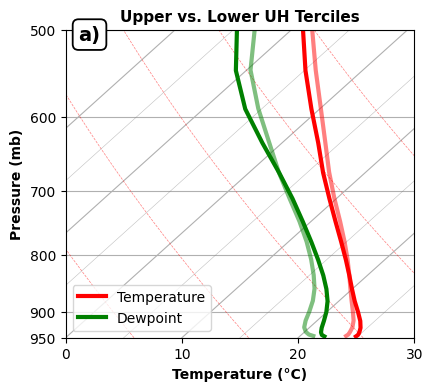

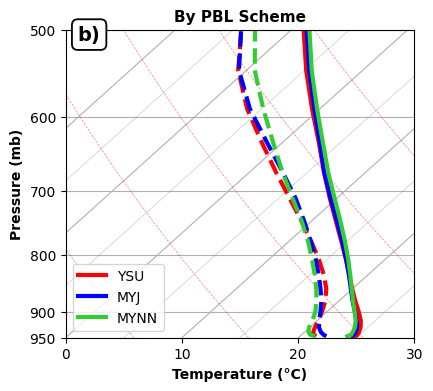

In [12]:
save=True

fig = plt.figure(figsize=(4.5,4))

spec = fig.add_gridspec(ncols=80, nrows=20 )

skew = SkewT(fig, rotation=48, aspect='auto')

skew.ax.set_ylim(950, 500)
skew.ax.set_xlim(0, 30)
skew.plot_dry_adiabats(t0=np.arange(-40,51,10)*units.degree_Celsius, lw=0.5)

skew.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),25), c='gray', lw=0.4, alpha=0.5)
skew.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),15), c='gray', lw=0.4, alpha=0.5)
skew.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),5), c='gray', lw=0.4, alpha=0.5)
skew.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),-5), c='gray', lw=0.4, alpha=0.5)
skew.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),-15), c='gray', lw=0.4, alpha=0.5)

skew.plot(p_upp_mean, t_upp_mean, 'r', lw=3)
skew.plot(p_upp_mean, td_upp_mean, 'green', lw=3)

skew.plot(p_low_mean, t_low_mean, 'r', lw=3, alpha=0.5)
skew.plot(p_low_mean, td_low_mean, 'green', lw=3, alpha=0.5)

skew.ax.set_yticks([950,900,800,700,600,500])
plt.xlabel('Temperature (°C)', size=10, weight='bold')
plt.ylabel('Pressure (mb)', size=10, weight='bold')

red_line = mlines.Line2D([], [], color='r', lw=3, label='Temperature')
green_line = mlines.Line2D([], [], color='g', lw=3, label='Dewpoint')
skew.ax.legend(handles=[red_line, green_line], loc='lower left')

skew.ax.text(0.1, 1.015, 'a)', transform=skew.ax.transAxes, weight='bold',
              verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='w', edgecolor='k', pad=0.3, lw=1.3, boxstyle='round'), size=14)

plt.title('Upper vs. Lower UH Terciles', size=11, weight='bold')

if save == True:
    plt.savefig(fname=f'{outplot_path}/sounding_{case}_terc.png', dpi=300, bbox_inches='tight', facecolor='w')
    
fig = plt.figure(figsize=(4.5,4))

skew2 = SkewT(fig, rotation=48, aspect='auto')
skew2.ax.set_ylim(950, 500)
skew2.ax.set_xlim(0, 30)
skew2.plot_dry_adiabats(t0=np.arange(-40,51,10)*units.degree_Celsius, lw=0.5, label='_nolegend_')

skew2.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),25), c='gray', lw=0.4, alpha=0.5)
skew2.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),15), c='gray', lw=0.4, alpha=0.5)
skew2.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),5), c='gray', lw=0.4, alpha=0.5)
skew2.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),-5), c='gray', lw=0.4, alpha=0.5)
skew2.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),-15), c='gray', lw=0.4, alpha=0.5)

skew2.plot(p_ysu, t_ysu, c='r', lw=3)
skew2.plot(p_myj, t_myj, color='b', lw=3)
skew2.plot(p_mynn, t_mynn, color='limegreen', lw=3)

skew2.plot(p_ysu, td_ysu, c='r', lw=3, ls='--')
skew2.plot(p_myj, td_myj, c='b', lw=3, ls='--')
skew2.plot(p_mynn, td_mynn, color='limegreen', lw=3, ls='--')

skew2.ax.set_yticks([950,900,800,700,600,500])

plt.xlabel('Temperature (°C)', size=10, weight='bold')
plt.ylabel('Pressure (mb)', size=10, weight='bold')

red_line = mlines.Line2D([], [], color='r', lw=3, label='YSU')
green_line = mlines.Line2D([], [], color='limegreen', lw=3, label='MYNN')
blue_line = mlines.Line2D([], [], color='b', lw=3, label='MYJ')

skew2.ax.legend(handles=[red_line, blue_line, green_line], loc='lower left')

skew2.ax.text(0.1, 1.015, 'b)', transform=skew2.ax.transAxes, weight='bold',
              verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='w', edgecolor='k', pad=0.3, lw=1.3, boxstyle='round'), size=14)

plt.title('By PBL Scheme', size=11, weight='bold')
save=True
if save == True:
    plt.savefig(fname=f'{outplot_path}/sounding_{case}_pbl.png', dpi=300, bbox_inches='tight', facecolor='w')


### Same as cell above but for tercile comparison only; kept to retain Fig. 13c formatting

Text(0.5, 1.0, 'Upper vs. Lower Tercile Sounding')

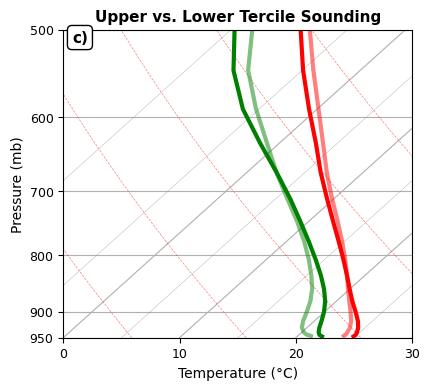

In [13]:
fig = plt.figure(figsize=(4.5,4))

skew2 = SkewT(fig, rotation=48, aspect='auto')
skew2.ax.set_ylim(950, 500)
skew2.ax.set_xlim(0, 30)
skew2.plot_dry_adiabats(t0=np.arange(-40,51,10)*units.degree_Celsius, lw=0.5, label='_nolegend_')

skew2.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),25), c='gray', lw=0.4, alpha=0.5)
skew2.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),15), c='gray', lw=0.4, alpha=0.5)
skew2.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),5), c='gray', lw=0.4, alpha=0.5)
skew2.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),-5), c='gray', lw=0.4, alpha=0.5)
skew2.plot(np.arange(1100,200,-1), np.full_like(np.arange(1100,200,-1),-15), c='gray', lw=0.4, alpha=0.5)

skew2.plot(p_upp_mean, t_upp_mean, 'r', lw=3)
skew2.plot(p_upp_mean, td_upp_mean, 'g', lw=3)

skew2.plot(p_low_mean, t_low_mean, 'r', lw=3, alpha=0.5)
skew2.plot(p_low_mean, td_low_mean, 'g', lw=3, alpha=0.5)

skew2.ax.set_xticks([0,10,20,30])
skew2.ax.set_xticklabels([0,10,20,30], size=9)

skew2.ax.set_yticks([950,900,800,700,600,500])
skew2.ax.set_yticklabels([950,900,800,700,600,500], size=9)

plt.xlabel('Temperature (°C)', size=10)
plt.ylabel('Pressure (mb)', size=10)

#red_line = mlines.Line2D([], [], color='r', lw=3, label='YSU')
#green_line = mlines.Line2D([], [], color='g', lw=3, label='MYNN')
#blue_line = mlines.Line2D([], [], color='b', lw=3, label='MYJ')

#skew2.ax.legend(handles=[red_line, blue_line, green_line], loc='lower left')

#skew2.ax.text(0.1, 1.015, 'b)', transform=skew2.ax.transAxes, weight='bold',
#              verticalalignment='top', horizontalalignment='right',
#            bbox=dict(facecolor='w', edgecolor='k', pad=0.3, lw=1.3, boxstyle='round'), size=14)

skew2.ax.text(0.025, 0.96, 'c)', color='k', transform=skew2.ax.transAxes,
        bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'),
        size=11, weight='bold')

plt.title('Upper vs. Lower Tercile Sounding', size=11, weight='bold')

#if save == True:
#    plt.savefig(fname=f'paper_figures/sounding_{case}_pbl.png', dpi=300, bbox_inches='tight', facecolor='w')


## Fig. S5a: Full Sounding w/ Parcel Trace by Tercile

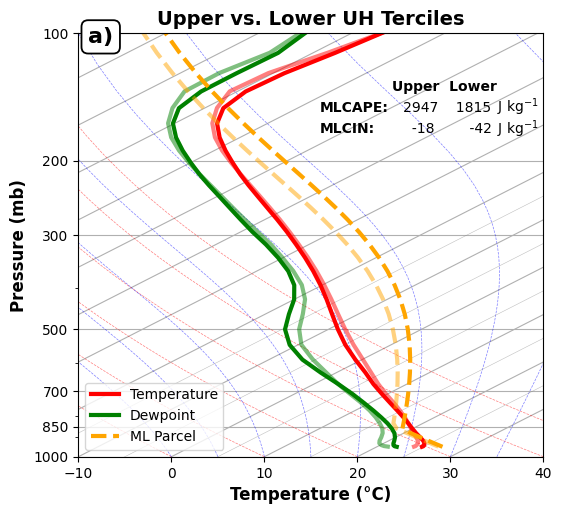

In [14]:
save=True

fig = plt.figure(figsize=(6,5.5))

spec = fig.add_gridspec(ncols=80, nrows=20 )

skew = SkewT(fig, rotation=63, aspect='auto')

mlparc_upp = mpcalc.mixed_parcel(p_upp_mean*units.hectopascal, 
                                     t_upp_mean*units.degC, 
                                     td_upp_mean*units.degC, 
                                     depth=100*units.hectopascal)

mlparc_low = mpcalc.mixed_parcel(p_low_mean*units.hectopascal, 
                                     t_low_mean*units.degC, 
                                     td_low_mean*units.degC, 
                                     depth=100*units.hectopascal)

parc_prof_upp = mpcalc.parcel_profile(p_upp_mean*units.hectopascal, 
                                      mlparc_upp[1], 
                                      mlparc_upp[2])
parc_prof_low = mpcalc.parcel_profile(p_low_mean*units.hectopascal, 
                                      mlparc_low[1], 
                                      mlparc_low[2])

mlcape_upp, mlcin_upp = mpcalc.mixed_layer_cape_cin(p_upp_mean*units.hectopascal,
                                                   t_upp_mean*units.degC,
                                                   td_upp_mean*units.degC)
mlcape_low, mlcin_low = mpcalc.mixed_layer_cape_cin(p_low_mean*units.hectopascal,
                                                   t_low_mean*units.degC,
                                                   td_low_mean*units.degC)


skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-10, 40)
skew.plot_dry_adiabats(t0=np.arange(-40,51,10)*units.degree_Celsius, lw=0.5)
skew.plot_moist_adiabats(lw=0.5)
#skew.plot_mixing_lines(lw=0.5)

skew.plot(np.arange(1100,100,-1), np.full_like(np.arange(1100,100,-1),25), c='gray', lw=0.4, alpha=0.5)
skew.plot(np.arange(1100,100,-1), np.full_like(np.arange(1100,100,-1),15), c='gray', lw=0.4, alpha=0.5)
skew.plot(np.arange(1100,100,-1), np.full_like(np.arange(1100,100,-1),5), c='gray', lw=0.4, alpha=0.5)
skew.plot(np.arange(1100,100,-1), np.full_like(np.arange(1100,100,-1),-5), c='gray', lw=0.4, alpha=0.5)
skew.plot(np.arange(1100,100,-1), np.full_like(np.arange(1100,100,-1),-15), c='gray', lw=0.4, alpha=0.5)

skew.plot(p_upp_mean, t_upp_mean, 'r', lw=3)
skew.plot(p_upp_mean, td_upp_mean, 'green', lw=3)

skew.plot(p_low_mean, t_low_mean, 'r', lw=3, alpha=0.5)
skew.plot(p_low_mean, td_low_mean, 'green', lw=3, alpha=0.5)

skew.plot(p_upp_mean, parc_prof_upp, 'orange', lw=3, ls='--', alpha=1)
skew.plot(p_low_mean, parc_prof_low, 'orange', lw=3, ls='--', alpha=0.5)

skew.ax.set_yticks([1000,850,700,500,300,200,100])
plt.xlabel('Temperature (°C)', size=12, weight='bold')
plt.ylabel('Pressure (mb)', size=12, weight='bold')

red_line = mlines.Line2D([], [], color='r', lw=3, label='Temperature')
green_line = mlines.Line2D([], [], color='g', lw=3, label='Dewpoint')
dash_line = mlines.Line2D([], [], color='orange', lw=3, ls='--', label='ML Parcel')
skew.ax.legend(handles=[red_line, green_line, dash_line], loc='lower left')

skew.ax.text(0.075, 1.015, 'a)', transform=skew.ax.transAxes, weight='bold',
              verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='w', edgecolor='k', pad=0.3, lw=1.3, boxstyle='round'), size=16)

skew.ax.text(0.675, 0.89, f'Upper  Lower', transform=skew.ax.transAxes, weight='bold',
              verticalalignment='top', horizontalalignment='left', size=10)
skew.ax.text(0.52, 0.84, f'MLCAPE:', transform=skew.ax.transAxes, weight='bold',
              verticalalignment='top', horizontalalignment='left', size=10)
skew.ax.text(0.52, 0.79, f'MLCIN:', transform=skew.ax.transAxes, weight='bold',
              verticalalignment='top', horizontalalignment='left', size=10)

skew.ax.text(0.67, 0.84, f'   {round(mlcape_upp.magnitude)}    {round(mlcape_low.magnitude)}', transform=skew.ax.transAxes,
              verticalalignment='top', horizontalalignment='left', size=10)
skew.ax.text(0.67, 0.79, f'     {round(mlcin_upp.magnitude)}        {round(mlcin_low.magnitude)}', transform=skew.ax.transAxes,
              verticalalignment='top', horizontalalignment='left', size=10)
skew.ax.text(0.9, 0.80, 'J kg$^{{-1}}$', transform=skew.ax.transAxes,
              verticalalignment='top', horizontalalignment='left', size=10)
skew.ax.text(0.9, 0.85, 'J kg$^{{-1}}$', transform=skew.ax.transAxes,
              verticalalignment='top', horizontalalignment='left', size=10)

plt.title('Upper vs. Lower UH Terciles', size=14, weight='bold')

save=True
if save == True:
    plt.savefig(fname=f'{outplot_path}/sounding_{case}_cape.png', dpi=300, bbox_inches='tight', facecolor='w')

## Compute CAPE/CIN Stats by Tercile

In [15]:
mlcapes_upp, mlcins_upp = [],[]
for i in range(len(upp_terc)):
    mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p_upp[i]*units.hectopascal, 
                              t_upp[i]*units.degree_Celsius, 
                              td_upp[i]*units.degree_Celsius)
    
    mlcapes_upp.append(mlcape.magnitude), mlcins_upp.append(mlcin.magnitude)

mlcapes_low, mlcins_low = [],[]
for i in range(len(low_terc)):
    mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p_low[i]*units.hectopascal, 
                              t_low[i]*units.degree_Celsius, 
                              td_low[i]*units.degree_Celsius)

    mlcapes_low.append(mlcape.magnitude), mlcins_low.append(mlcin.magnitude)

#mpcalc.most_unstable_cape_cin(p_upp[0]*units.hectopascal, t_upp[0]*units.degree_Celsius, td_upp[0]*units.degree_Celsius)

sbcapes_upp, sbcins_upp = [],[]
for i in range(len(upp_terc)):
    sbcape, sbcin = mpcalc.surface_based_cape_cin(p_upp[i]*units.hectopascal, 
                              t_upp[i]*units.degree_Celsius, 
                              td_upp[i]*units.degree_Celsius)
    
    sbcapes_upp.append(sbcape.magnitude), sbcins_upp.append(sbcin.magnitude)

sbcapes_low, sbcins_low = [],[]
for i in range(len(low_terc)):
    sbcape, sbcin = mpcalc.surface_based_cape_cin(p_low[i]*units.hectopascal, 
                              t_low[i]*units.degree_Celsius, 
                              td_low[i]*units.degree_Celsius)

    sbcapes_low.append(sbcape.magnitude), sbcins_low.append(sbcin.magnitude)

#mpcalc.most_unstable_cape_cin(p_upp[0]*units.hectopascal, t_upp[0]*units.degree_Celsius, td_upp[0]*units.degree_Celsius)

print('MLCAPE:\n-------------')
print('Upper tercile:', np.nanmean(mlcapes_upp))
print('Lower tercile:', np.nanmean(mlcapes_low), '\n')
print('MLCIN:\n-------------')
print('Upper tercile:', np.nanmean(mlcins_upp))
print('Lower tercile:', np.nanmean(mlcins_low), '\n')
print('SBCAPE:\n-------------')
print('Upper tercile:', np.nanmean(sbcapes_upp))
print('Lower tercile:', np.nanmean(sbcapes_low), '\n')
print('SBCIN:\n-------------')
print('Upper tercile:', np.nanmean(sbcins_upp))
print('Lower tercile:', np.nanmean(sbcins_low))

MLCAPE:
-------------
Upper tercile: 2961.409324782673
Lower tercile: 1885.444296658283 

MLCIN:
-------------
Upper tercile: -18.959388167309676
Lower tercile: -50.79766364811345 

SBCAPE:
-------------
Upper tercile: 3533.890007876822
Lower tercile: 2530.5741944229235 

SBCIN:
-------------
Upper tercile: -29.646931907471224
Lower tercile: -55.744792350434004


## Compute CAPE/CIN Stats by PBL Scheme

In [16]:
mlcins = np.nanmean(np.where( (dist < nf_dist) | (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (ang_diff > ang_thres) | (pstat > pthres) | np.isnan(pstat), np.nan, ds_ref.MLCIN), axis=(1,2,3))
mlcapes = np.nanmean(np.where( (dist < nf_dist) | (dist > ff_dist) | (ang_tot > ang_bound1) & (ang_tot < ang_bound2) | (ang_diff > ang_thres) | (pstat > pthres) | np.isnan(pstat), np.nan, ds_ref.MLCAPE), axis=(1,2,3))

print('MLCAPE:\n-------------')
print('YSU: ' + str(np.nanmean(mlcapes[ysu_idx])) + 'j/kg')
print('MYJ: ' + str(np.nanmean(mlcapes[myj_idx])) + 'j/kg')
print('MYNN: ' + str(np.nanmean(mlcapes[mynn_idx])) + 'j/kg\n')

print('MLCIN:\n-------------')
print('YSU: ' + str(np.nanmean(mlcins[ysu_idx])) + 'j/kg')
print('MYJ: ' + str(np.nanmean(mlcins[myj_idx])) + 'j/kg')
print('MYNN: ' + str(np.nanmean(mlcins[mynn_idx])) + 'j/kg')


MLCAPE:
-------------
YSU: 2998.296j/kg
MYJ: 3211.7256j/kg
MYNN: 3172.613j/kg

MLCIN:
-------------
YSU: -5.553696j/kg
MYJ: -4.8734183j/kg
MYNN: -5.457039j/kg
